In [1]:
%matplotlib notebook

In [2]:
import subprocess as sp
from subprocess import call
import pysam as ps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gzip
import shutil
from os import remove, getcwd, makedirs
from os.path import join, exists, dirname, basename
from matplotlib.ticker import FormatStrFormatter

In [3]:
notebook_dir = getcwd()

rtg_bin = '/Users/dcooke/Genomics/apps/rtg-tools/rtg'
rtg_ref = '/Users/dcooke/Genomics/references/human/GRCh37_SDF'

somatic_dir = dirname(notebook_dir)
paper_dir = dirname(somatic_dir)
germline_dir = join(paper_dir, "germline")
germline_truth_dir = join(germline_dir, "truth")
somatic_truth_dir = join(somatic_dir, "truth")

call_dir = join(notebook_dir, "calls")
eval_dir = join(notebook_dir, "eval")

callers = ['Octopus', 'Pisces']

tumour_types = ['skin', 'breast']

somatic_truth_vcfs = {
    'skin': join(somatic_truth_dir, "skin.vcf.gz"),
    'breast': join(somatic_truth_dir, "breast.vcf.gz")
}

germline_truth_vcfs = {
    'skin': join(germline_truth_dir, "HG001/HG001.vcf.gz"),
    'breast': join(germline_truth_dir, "HG001/HG001.vcf.gz")
}

somatic_evaluation_beds = {
    'skin': join(somatic_truth_dir, 'skin.bed'),
    'breast': join(somatic_truth_dir, 'breast.bed')
}

germline_evaluation_beds = {
    'skin': join(germline_truth_dir, 'HG001/HG001.bed'),
    'breast': join(germline_truth_dir, 'HG001/HG001.bed')
}

caller_score_metric = {
    'Octopus': 'FORMAT.RFQUAL',
    'Pisces': 'QUAL'
}

caller_colours = {
    'Octopus': sns.xkcd_rgb["windows blue"],
    'Pisces': sns.xkcd_rgb["amber"]
}

caller_linestyles = {
    'Octopus': '',
    'Pisces': (2,2)
}

methods = ['combined', 'curated', 'somatic', 'misclassified']

method_linestyles = {
    'combined': '',
    'curated': (2,2),
    'somatic': (3,1),
    'misclassified': (1,1)
}

sample_names = {
    'skin': 'NA12878.TUMOUR',
    'breast': 'NA12878.TUMOUR'
}

temp_dir = join(notebook_dir, "temp")

def get_vcf_path(tumour_type, caller):
    return join(join(call_dir, tumour_type), caller + '.vcf.gz')

def get_eval_dir(tumour_type, caller):
    return join(join(eval_dir, tumour_type), caller)

caller_vcfs = {}
rtg_eval_dirs = {}

for tumour_type in tumour_types:
    caller_vcfs[tumour_type] = {}
    rtg_eval_dirs[tumour_type] = {}
    for caller in callers:
        caller_vcfs[tumour_type][caller] = get_vcf_path(tumour_type, caller)
        rtg_eval_dirs[tumour_type][caller] = get_eval_dir(tumour_type, caller)

In [4]:
plt.rcParams['figure.figsize'] = [9, 6]
pd.options.display.float_format = '{:,.3f}'.format

In [25]:
def run_rtg_vcfeval(caller_vcf, truth_vcf, out_dir,
                    squash_ploidy=False,
                    score_metric=None,
                    evaluation_regions=None, 
                    include_filtered=False):
    rtg_cmd = [rtg_bin, 'vcfeval', '-t', rtg_ref, '-b', truth_vcf, '-c', caller_vcf, '-o', out_dir, '--ref-overlap']
    if squash_ploidy:
        rtg_cmd.append('--squash-ploidy')
    if evaluation_regions is not None:
        rtg_cmd += ['--bed-regions', evaluation_regions]
    if score_metric is not None:
        rtg_cmd += ['-f', score_metric]
    if include_filtered:
        rtg_cmd.append('--all-records')
    call(rtg_cmd)

def prepare_octopus_vcf_for_rtg(octopus_vcf, tumour_sample):
    """"
    Octopus reports non-diploid genotypes for somatic variants.
    """
    in_vcf = ps.VariantFile(octopus_vcf)
    out_vcf_name = octopus_vcf.replace('.vcf', '.rtg_compatible.vcf')
    out_vcf = ps.VariantFile(out_vcf_name, 'w', header=in_vcf.header)
    n_failed = 0
    for record in in_vcf:
        old_gt = record.samples[tumour_sample]['GT']
        assert(len(old_gt) > 1)
        if 'SOMATIC' in record.info:
            if any(old_gt):
                somatic_allele = next(a for a in reversed(list(old_gt)) if a is not None and a > 0)
                record.samples[tumour_sample]['GT'] = (old_gt[0], somatic_allele)
            else:
                n_failed += 1
                continue
        elif len(old_gt) > 2:
            record.samples[tumour_sample]['GT'] = old_gt[0], old_gt[1]
        try:
            out_vcf.write(record)
        except OSError:
            n_failed += 1
    return out_vcf_name

def rename_vcf_sample(in_vcf_name, out_vcf_name, sample):
    bcftools_cmd = ['bcftools', 'view', in_vcf_name]
    awk_expression = 'BEGIN {FS="\t"; OFS=FS;} {if (NF < 10) print; else if ($1=="#CHROM") { $10="' + sample + '"; print; } else {print}}'
    awk_cmd = ['awk', awk_expression]
    bgzip_cmd = ['bgzip']
    out_vcf = open(out_vcf_name, 'w')
    bcftools = sp.Popen(bcftools_cmd, stdout=sp.PIPE)
    awk = sp.Popen(awk_cmd, stdin=bcftools.stdout, stdout=sp.PIPE)
    bgzip = sp.Popen(bgzip_cmd, stdin=awk.stdout, stdout=out_vcf)
    bcftools.stdout.close()
    output = bgzip.communicate()[0]
    return out_vcf_name

def prepare_pisces_vcf_for_rtg(pisces_vcf, tumour_sample):
    """"
    Pisces outputs incorrect tumour sample name.
    """
    out_vcf_name = pisces_vcf.replace('.vcf', '.rtg_compatible.vcf')
    rename_vcf_sample(pisces_vcf, out_vcf_name, tumour_sample)
    return out_vcf_name

def prepare_caller_vcf_for_rtg(caller_vcf, caller, tumour_type):
    tumour_sample = sample_names[tumour_type]
    if "Octopus" in caller:
        return prepare_octopus_vcf_for_rtg(caller_vcf, tumour_sample)
    elif caller == "Pisces":
        return prepare_pisces_vcf_for_rtg(caller_vcf, tumour_sample)
    return None

def index(vcf_path):
    call(['tabix', vcf_path])
    return vcf_path + '.tbi'

def remove_vcf(vcf_path):
    remove(vcf_path)
    if exists(vcf_path + '.tbi'):
        remove(vcf_path + '.tbi')

def classifies_somatic_calls(caller):
    return 'Octopus' in caller or caller == 'Pisces'

def copy_germline_calls(caller, src, dest):
    if classifies_somatic_calls(caller):
        bcftools_cmd = ['bcftools', 'view', '-e', 'INFO/SOMATIC=1', '-Oz', '-o', dest, src]
        sp.call(bcftools_cmd)
    else:
        shutil.copyfile(src, dest)
    index(dest)

def copy_somatic_calls(caller, src, dest):
    if classifies_somatic_calls(caller):
        bcftools_cmd = ['bcftools', 'view', '-i', 'INFO/SOMATIC=1', '-Oz', '-o', dest, src]
        sp.call(bcftools_cmd)
    else:
        raise Error(caller + " does not classify somatic calls")
    index(dest)

def evaluate_germline(caller, caller_vcf, tumour_type, out_dir, overwrite=False):
    truth_vcf = germline_truth_vcfs[tumour_type]
    eval_bed = germline_evaluation_beds[tumour_type]
    if not exists(caller_vcf):
        print("Cannot evaluate " + caller + " as " + caller_vcf + " does not exist")
        return
    rtg_vcf = prepare_caller_vcf_for_rtg(caller_vcf, caller, tumour_type)
    if rtg_vcf is not None:
        caller_vcf = rtg_vcf
        index(rtg_vcf)
    if exists(out_dir):
        if type(overwrite) is not bool:
            overwrite = caller in overwrite
        if overwrite:
            shutil.rmtree(out_dir)
        else:
            print('Found existing evaluation: ' + out_dir)
            return
    run_rtg_vcfeval(rtg_vcf, truth_vcf, out_dir, 
                    score_metric=caller_score_metric[caller],
                    evaluation_regions=eval_bed)
    if rtg_vcf is not None:
        remove_vcf(rtg_vcf)

def intersect_beds(in1, in2, out):
    bedtools_cmd = ['bedtools', 'intersect', '-a', in1, '-b', in2]
    out_bed = open(out, 'w')
    call(bedtools_cmd, stdout=out_bed)

def evaluate_somatic(caller, caller_vcf, tumour_type, out_dir, overwrite=False):
    truth_vcf = somatic_truth_vcfs[tumour_type]
    eval_bed = join(temp_dir, tumour_type + '.bed')
    intersect_beds(germline_evaluation_beds[tumour_type], somatic_evaluation_beds[tumour_type], eval_bed)
    if not exists(caller_vcf):
        print("Cannot evaluate " + caller + " as " + caller_vcf + " does not exist")
        return
    rtg_vcf = prepare_caller_vcf_for_rtg(caller_vcf, caller, tumour_type)
    if rtg_vcf is not None:
        caller_vcf = rtg_vcf
        index(rtg_vcf)
    if exists(out_dir):
        if type(overwrite) is not bool:
            overwrite = caller in overwrite
        if overwrite:
            shutil.rmtree(out_dir)
        else:
            print('Found existing evaluation: ' + out_dir)
            return
    run_rtg_vcfeval(caller_vcf, truth_vcf, out_dir,
                    squash_ploidy=True,
                    score_metric=caller_score_metric[caller],
                    evaluation_regions=eval_bed)
    if rtg_vcf is not None:
        remove_vcf(rtg_vcf)
        remove(eval_bed)

def merge_vcfs(a, b, dest, sample_name=None):
    cmd = ['bcftools', 'concat', '-a', '-Oz', '-o', dest, a, b]
    res = sp.call(cmd)
    index(dest)
    return res

def evaluate_germline_and_somatic(caller, caller_vcf, tumour_type, out_dir, overwrite=False):
    if not exists(temp_dir):
        makedirs(temp_dir)
    germline_truth_vcf = germline_truth_vcfs[tumour_type]
    renamed_germline_truth_vcf = join(temp_dir, basename(germline_truth_vcf))
    rename_vcf_sample(germline_truth_vcf, renamed_germline_truth_vcf, sample_names[tumour_type])
    index(renamed_germline_truth_vcf)
    somatic_truth_vcf = somatic_truth_vcfs[tumour_type]
    truth_vcf = join(temp_dir, 'merged_truth.vcf.gz')
    merge_vcfs(renamed_germline_truth_vcf, somatic_truth_vcf, truth_vcf)
    index(truth_vcf)
    remove_vcf(renamed_germline_truth_vcf)
    eval_bed = join(temp_dir, tumour_type + '.bed')
    intersect_beds(germline_evaluation_beds[tumour_type], somatic_evaluation_beds[tumour_type], eval_bed)
    if not exists(caller_vcf):
        print("Cannot evaluate " + caller + " as " + caller_vcf + " does not exist")
        return
    rtg_vcf = prepare_caller_vcf_for_rtg(caller_vcf, caller, tumour_type)
    if rtg_vcf is not None:
        caller_vcf = rtg_vcf
        index(rtg_vcf)
    if exists(out_dir):
        if type(overwrite) is not bool:
            overwrite = caller in overwrite
        if overwrite:
            shutil.rmtree(out_dir)
        else:
            print('Found existing evaluation: ' + out_dir)
            return
    run_rtg_vcfeval(caller_vcf, truth_vcf, out_dir, 
                    score_metric=caller_score_metric[caller],
                    evaluation_regions=eval_bed)
    if rtg_vcf is not None:
        remove_vcf(rtg_vcf)
        remove(eval_bed)
        remove_vcf(truth_vcf)

def evaluate_caller(caller, tumour_type, overwrite=False):
    caller_eval_dir = rtg_eval_dirs[tumour_type][caller]
    caller_vcf = caller_vcfs[tumour_type][caller]
    
    # Evaluate germline and somatic calls together
    combined_eval_dir = join(caller_eval_dir, 'combined')
    evaluate_germline_and_somatic(caller, caller_vcf, tumour_type, combined_eval_dir, overwrite=overwrite)
    
    # Evaluate curated somatic calls by artificially removing non-germline calls
    germline_temp_eval_dir = join(temp_dir, caller + '.germline.eval')
    evaluate_germline(caller, caller_vcf, tumour_type, germline_temp_eval_dir)
    fp_germline_vcf = join(germline_temp_eval_dir, 'fp.vcf.gz')
    curated_somatic_eval_dir = join(caller_eval_dir, 'curated')
    evaluate_somatic(caller, fp_germline_vcf, tumour_type, curated_somatic_eval_dir)
    shutil.rmtree(germline_temp_eval_dir)
    
    if classifies_somatic_calls(caller):
        # Evaluate called somatic mutations
        somatic_temp_vcf = join(temp_dir, basename(caller_vcf).replace('.vcf', '.somatic.vcf'))
        copy_somatic_calls(caller, caller_vcf, somatic_temp_vcf)
        somatic_eval_dir = join(caller_eval_dir, 'somatic')
        evaluate_somatic(caller, somatic_temp_vcf, tumour_type, somatic_eval_dir, overwrite=overwrite)
        
        # Evaluate incorrectly classified germline mutations
        germline_temp_vcf = join(temp_dir, basename(caller_vcf).replace('.vcf', '.germline.vcf'))
        copy_germline_calls(caller, caller_vcf, germline_temp_vcf)
        evaluate_germline(caller, germline_temp_vcf, tumour_type, germline_temp_eval_dir)
        misclassified_somatic_eval_dir = join(caller_eval_dir, 'misclassified')
        evaluate_somatic(caller, fp_germline_vcf, tumour_type, misclassified_somatic_eval_dir, overwrite=overwrite)
        shutil.rmtree(germline_temp_eval_dir)

def evaluate_callers(callers, tumour_type, overwrite=False):
    for caller in callers:
        evaluate_caller(caller, tumour_type, overwrite=overwrite)

def evaluate_everything(overwrite=False):
    for tumour_type in tumour_types:
        evaluate_callers(callers, tumour_type, overwrite=overwrite)

In [16]:
def read_caller_performance_summary(caller, method, rtg_eval_dir):
    summary_fname = join(rtg_eval_dir, 'summary.txt')
    with open(summary_fname) as f:
        lines = f.readlines()
        header, stats = lines[0].strip().split(), lines[-1].strip().split()
        assert len(header) == len(stats)
        result = pd.DataFrame([[caller, method]], columns=['caller', 'method'])
        for field, stat in zip(header, stats):
            if field != "Threshold":
                result[field] = stat
        return result
    return None

def read_performance_summaries(rtg_eval_dirs):
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            for method in methods:
                method_eval_dir = join(rtg_eval_dir, method)
                if exists(method_eval_dir):
                    caller_dfs.append(read_caller_performance_summary(caller, method, method_eval_dir))
    return pd.concat(caller_dfs)

def plot_bar(df, metric='FDR', y_limit=None, save=None):
    sns.set_style("whitegrid")
    callers = list(df['caller'].unique())
    caller_palette = [caller_colours[caller] for caller in callers]
    g = sns.barplot(x="caller", y=metric, data=df, palette=caller_palette)
    if metric == 'FDR':
        g.set(ylabel='False Discovery Rate')
    elif metric == 'FNR':
        g.set(ylabel='False Negative Rate')
    if y_limit is not None:
        g.set(ylim=(0, y_limit))
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format='pdf', transparent=True, bbox_inches='tight')

In [30]:
def read_rtg_roc_header(rtg_roc):
    if rtg_roc.endswith('.gz'):
        f = gzip.open(rtg_roc, 'rt')
    else:
        f = open(rtg_roc)
    result = None
    for line in f:
        if line.startswith('#'):
            result = line.strip()[1:].split('\t')
        else:
            break
    return result

def get_rtg_roc_file(rtg_eval_dir, variant_type):
    if variant_type == 'snv' or variant_type == 'snp':
        roc_name = 'snp_roc.tsv.gz'
    elif variant_type == 'indel':
        roc_name = 'non_snp_roc.tsv.gz'
    else:
        roc_name = 'weighted_roc.tsv.gz'
    return join(rtg_eval_dir, roc_name)

def read_rtg_roc(rtg_eval_dir, variant_type='all', caller=None, method=None):
    rtg_roc = get_rtg_roc_file(rtg_eval_dir, variant_type)
    result = pd.read_csv(rtg_roc, sep='\t', comment='#')
    result.columns = read_rtg_roc_header(rtg_roc)
    if caller is not None:
        result['caller'] = caller
    if method is not None:
        result['method'] = method
    result.rename(columns={'sensitivity': 'recall'}, inplace=True)
    return result

def read_rtg_rocs(rtg_eval_dirs, variant_type='all'):
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            for method in methods:
                method_eval_dir = join(rtg_eval_dir, method)
                if exists(method_eval_dir):
                    caller_dfs.append(read_rtg_roc(method_eval_dir, variant_type=variant_type,
                                                   caller=caller, method=method))
    return pd.concat(caller_dfs)

def add_precision_recall(ax, roc_df, ylim=None, xlim=None,
                         y_format='%.3f', x_format='%.1f',
                         despine=True, title=None,
                         legend=True, legend_title=False):
    sns.set(style="whitegrid")
    if legend:
        legend = 'brief'
    sns.lineplot(x="recall", y="precision", hue="caller", #style="method",
                 palette=caller_colours, #dashes=method_linestyles,
                 hue_order=list(reversed(callers)),
                 legend=legend, 
                 data=roc_df.query('method == "somatic"'),
                 ax=ax)
    ax.set(ylabel='Precision (PPV)', xlabel='Recall')
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format))
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_format))
    if legend and not legend_title:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    if despine:
        sns.despine(ax=ax)
    if title is not None:
        ax.set(title=title)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    return ax

def plot_precision_recall(roc_df, ylim=None, xlim=None,
                          y_format='%.3f', x_format='%.1f', 
                          save=None, save_format='pdf'):
    fig, ax = plt.subplots()
    add_precision_recall(ax, roc_df, ylim=ylim, xlim=xlim, y_format=y_format, x_format=x_format)
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def plot_precision_recalls(df1, df2, title1=None, title2=None,
                           xlim1=None, ylim1=None, xlim2=None, ylim2=None,
                           y_format1='%.3f', x_format1='%.1f', y_format2='%.3f', x_format2='%.1f',
                           legend=True, save=None, save_format='pdf'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    add_precision_recall(ax1, df1, ylim=ylim1, xlim=xlim1, y_format=y_format1, x_format=x_format1,
                         title=title1, legend_title=True)
    add_precision_recall(ax2, df2, ylim=ylim2, xlim=xlim2, y_format=y_format2, x_format=x_format2,
                         title=title2, legend_title=True)
    ax2.set(ylabel='')
    if legend:
        handles, labels = ax2.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
    ax1.legend_.remove()
    ax2.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        if legend:
            plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
        else:
            plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

In [18]:
def get_vaf(truth_rec):
    return int(100 * truth_rec.info['VAF'])

def read_vafs(vcf_path):
    vcf = ps.VariantFile(vcf_path)
    return [get_vaf(rec) for rec in vcf]

def read_tp_vafs(rtg_eval_dir):
    return read_vafs(join(rtg_eval_dir, 'tp-baseline.vcf.gz'))

def read_fn_vafs(rtg_eval_dir):
    return read_vafs(join(rtg_eval_dir, 'fn.vcf.gz'))

def get_vaf_counts(vafs, possible_vafs):
    vaf_indices = {}
    for idx, vaf in enumerate(possible_vafs):
        vaf_indices[vaf] = idx
    res = [0 for _ in range(len(possible_vafs))]
    for vaf in vafs:
        res[vaf_indices[vaf]] += 1
    return res

def get_vaf_count_df(vafs, possible_vafs):
    vaf_counts = get_vaf_counts(vafs, possible_vafs)
    return pd.DataFrame(list(zip(possible_vafs, vaf_counts)), columns=['vafx2', 'count'])

def read_tp_vaf_count_df(rtg_eval_dir, possible_vafs):
    vafs = read_tp_vafs(rtg_eval_dir)
    return get_vaf_count_df(vafs, possible_vafs)

def read_truth_vaf_count_df(rtg_eval_dir):
    tp_vafs = read_tp_vafs(rtg_eval_dir)
    fn_vafs = read_fn_vafs(rtg_eval_dir)
    vafs = tp_vafs + fn_vafs
    possible_vafs = sorted(list(set(vafs)))
    return get_vaf_count_df(vafs, possible_vafs), possible_vafs

def read_caller_vaf_df(caller, rtg_eval_dir, truth_vaf_df=None, possible_vafs=None):
    if truth_vaf_df is None or possible_vafs is None:
        truth_vaf_df, possible_vafs = read_truth_vaf_count_df(rtg_eval_dir)
    result = read_tp_vaf_count_df(rtg_eval_dir, possible_vafs)
    result['caller'] = caller
    result['vaf'] = result['vafx2'] / 2
    result['tp'] = result['count']
    result['recall'] = result['tp'] / truth_vaf_df['count']
    result['FNR'] = 1. - result['recall']
    result = result[['caller', 'vaf', 'tp', 'recall', 'FNR']]
    return result

def read_vaf_df(rtg_eval_dirs, check_truths_match=True):
    if len(rtg_eval_dirs.keys()) == 0:
        return None
    truth_vaf_df, possible_vafs = None, None
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        rtg_eval_dir = join(rtg_eval_dir, 'somatic')
        if exists(rtg_eval_dir):
            if possible_vafs is None:
                truth_vaf_df, possible_vafs = read_truth_vaf_count_df(rtg_eval_dir)
            elif check_truths_match:
                caller_truth_vaf_df = read_truth_vaf_count_df(rtg_eval_dir)
                if not truth_vaf_df.equals(truth_vaf_df):
                    raise Exception("Derived truth sets do not match")
            caller_dfs.append(read_caller_vaf_df(caller, rtg_eval_dir, truth_vaf_df, possible_vafs))
    return pd.concat(caller_dfs)

def add_vaf_recall(ax, df, metric='recall', despine=True,
                   title=None, legend=True, legend_title=False):
    sns.set(style="whitegrid")
    if legend:
        legend = 'brief'
    sns.lineplot(x="vaf", y=metric, hue="caller", style="caller",
                 markers=True,
                 palette=caller_colours, dashes=caller_linestyles,
                 hue_order=list(reversed(callers)),
                 legend=legend, data=df, ax=ax)
    ax.set(xlabel='Variant Allele Frequency (%)')
    ax.set_ylim(0., 1.)
    if despine:
        sns.despine(ax=ax)
    if metric == 'recall':
        ax.set(ylabel='Recall')
    elif metric == 'FNR':
        ax.set(ylabel='False Negative Rate')
    if title is not None:
        ax.set(title=title)
    if legend and not legend_title:
        ax.legend().set_title('')

def plot_vaf_recall(df, metric='recall', title=None, save=None):
    fig, ax = plt.subplots()
    add_vaf_recall(ax, df, metric=metric, title=title)
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format='pdf', transparent=True, bbox_inches='tight')

def plot_vaf_recalls(df1, df2, title1=None, title2=None, legend=True, save=None, save_format='pdf'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    add_vaf_recall(ax1, df1, title=title1)
    add_vaf_recall(ax2, df2, title=title2)
    ax2.set(ylabel='')
    if legend:
        handles, labels = ax1.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels)-1)
    ax1.legend_.remove()
    ax2.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        if legend:
            plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
        else:
            plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

In [19]:
def read_performance_summaries_helper(tumour_type):
    return read_performance_summaries(rtg_eval_dirs[tumour_type])

def read_all_performance_summaries():
    dfs = []
    for tumour in tumour_types:
        df = read_performance_summaries_helper(tumour)
        df.insert(0, 'Test', tumour)
        dfs.append(df)
    return pd.concat(dfs)

def plot_vaf_recall_helper(tumour_type):
    plot_vaf_recall(read_vaf_df(rtg_eval_dirs[tumour_type]))

def plot_vaf_recalls_helper(tumour_type1, tumour_type2,
                            title1=None, title2=None, legend=True,
                            save=None, save_format='pdf'):
    df1 = read_vaf_df(rtg_eval_dirs[tumour_type1])
    df2 = read_vaf_df(rtg_eval_dirs[tumour_type2])
    plot_vaf_recalls(df1, df2, title1=title1, title2=title2, legend=legend,
                     save=save, save_format=save_format)

def plot_precision_recall_helper(tumour_type,
                                 ylim=None, xlim=None, y_format='%.3f', x_format='%.1f',
                                 save=None):
    plot_precision_recall(read_rtg_rocs(rtg_eval_dirs[tumour_type]),
                          ylim=ylim, xlim=xlim, y_format=y_format, x_format=x_format,
                          save=save)

def plot_precision_recalls_helper(tumour_type1, tumour_type2,
                                  xlim1=None, ylim1=None, xlim2=None, ylim2=None,
                                  y_format1='%.3f', x_format1='%.1f', y_format2='%.3f', x_format2='%.1f',
                                  title1=None, title2=None, legend=True, save=None, save_format='pdf'):
    df1 = read_rtg_rocs(rtg_eval_dirs[tumour_type1])
    df2 = read_rtg_rocs(rtg_eval_dirs[tumour_type2])
    plot_precision_recalls(df1, df2, title1=title1, title2=title2,
                           xlim1=xlim1, ylim1=ylim1, xlim2=xlim2, ylim2=ylim2,
                           y_format1=y_format1, x_format1=x_format1, y_format2=y_format2, x_format2=x_format2,
                           legend=legend, save=save, save_format=save_format)

In [26]:
evaluate_caller("Octopus", "skin")
evaluate_caller("Octopus", "breast")

In [27]:
read_performance_summaries_helper('skin')

,caller,method,True-pos-baseline,True-pos-call,False-pos,False-neg,Precision,Sensitivity,F-measure
0,Octopus,combined,3748037,3770554,11129,90523,0.9971,0.9764,0.9866
0,Octopus,curated,231740,231749,11173,30171,0.9540,0.8848,0.9181
0,Octopus,somatic,153332,153332,10740,108579,0.9345,0.5854,0.7199
0,Octopus,misclassified,78408,78417,5782,183503,0.9313,0.2994,0.4531
0,Pisces,combined,3711460,3718366,112203,127088,0.9707,0.9669,0.9688
0,Pisces,curated,221293,221294,112222,40618,0.6635,0.8449,0.7433
0,Pisces,somatic,65242,65242,71600,196669,0.4768,0.2491,0.3272
0,Pisces,misclassified,156050,156050,43102,105861,0.7836,0.5958,0.6769


In [40]:
evaluate_caller("octopus", "breast")

In [28]:
read_performance_summaries_helper('breast')

,caller,method,True-pos-baseline,True-pos-call,False-pos,False-neg,Precision,Sensitivity,F-measure
0,Octopus,combined,3624884,3648238,11566,71775,0.9968,0.9806,0.9886
0,Octopus,curated,3995,3995,11566,1510,0.2567,0.7257,0.3793
0,Octopus,somatic,3978,3978,9948,1527,0.2857,0.7226,0.4094
0,Octopus,misclassified,17,17,5885,5488,0.0029,0.0031,0.0030
0,Pisces,combined,3607097,3614212,124363,89555,0.9667,0.9758,0.9712
0,Pisces,curated,3168,3168,124363,2337,0.0248,0.5755,0.0476
0,Pisces,somatic,3115,3115,84648,2390,0.0355,0.5658,0.0668
0,Pisces,misclassified,53,53,42126,5452,0.0013,0.0096,0.0022


<IPython.core.display.Javascript object>


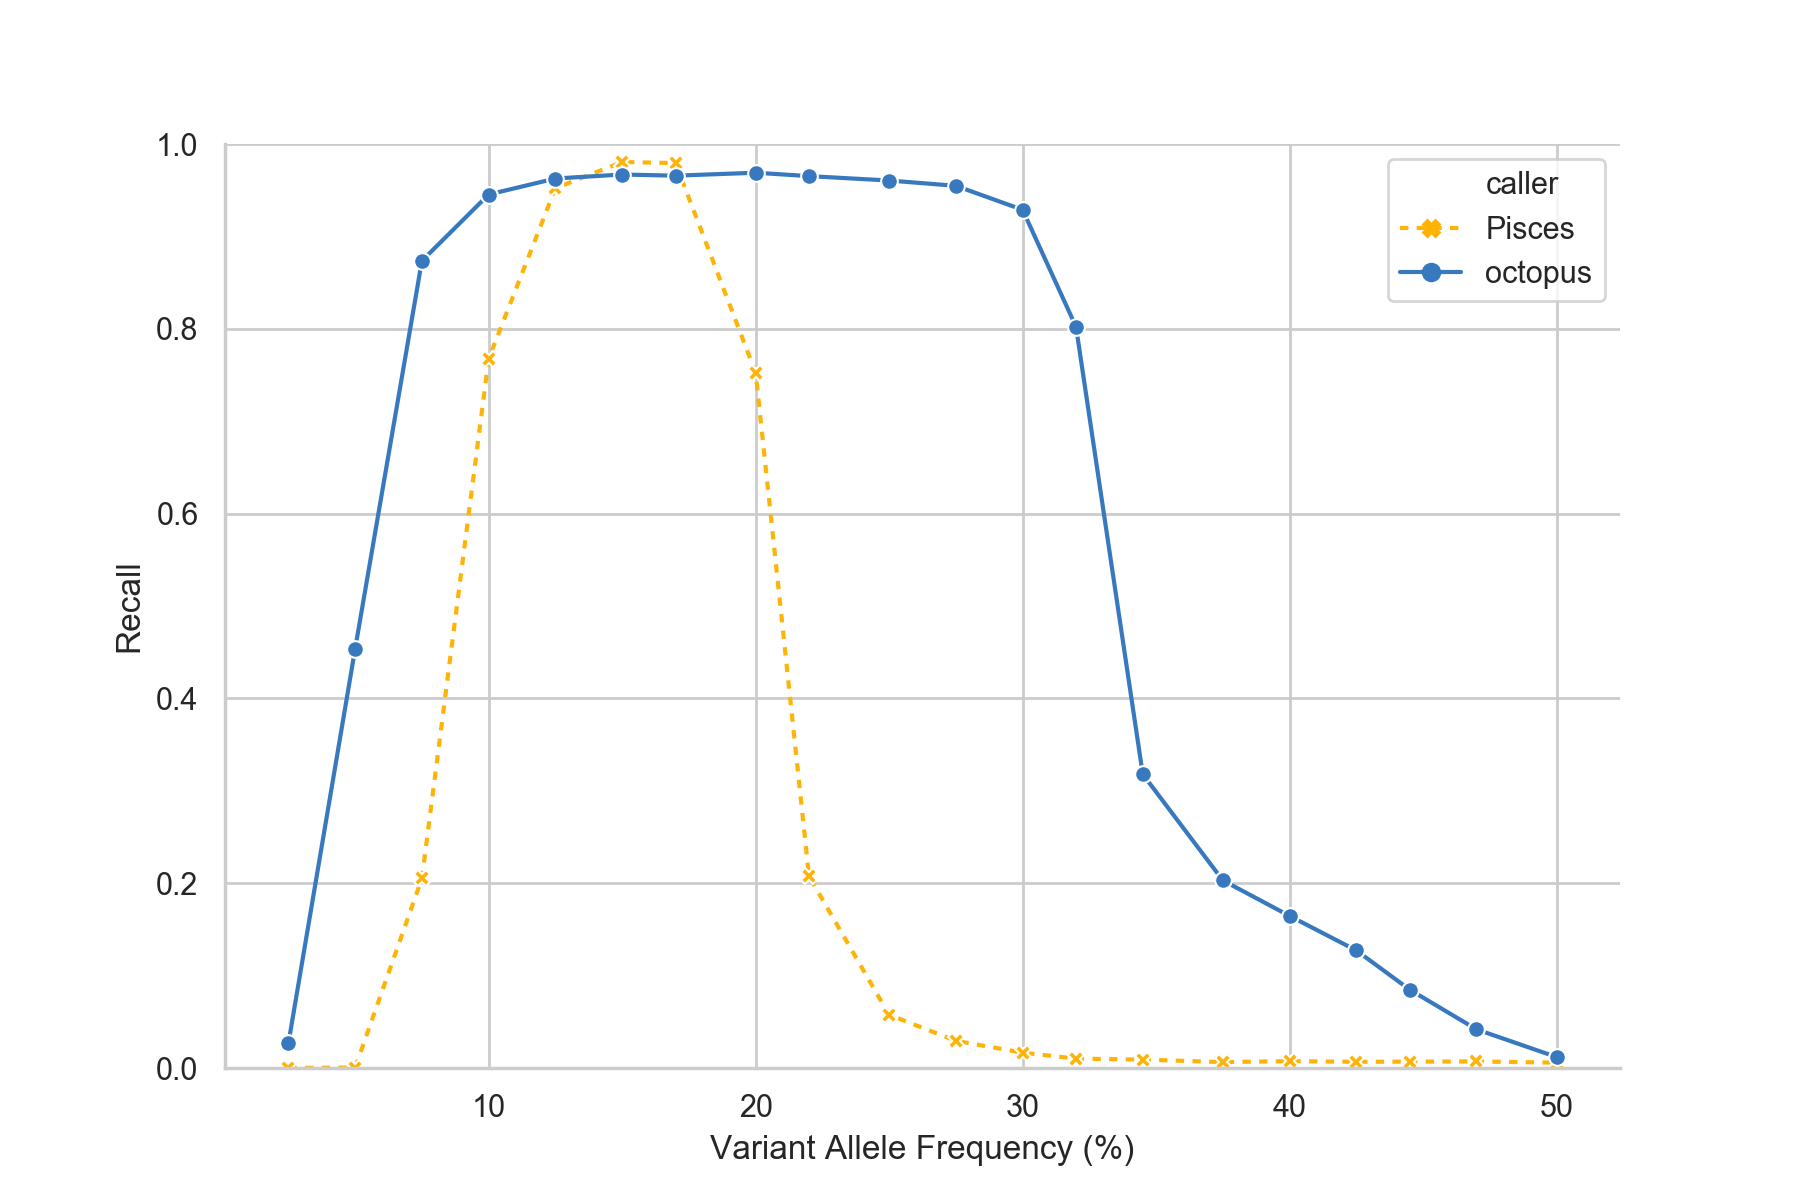

In [33]:
plot_vaf_recall_helper('skin')

<IPython.core.display.Javascript object>


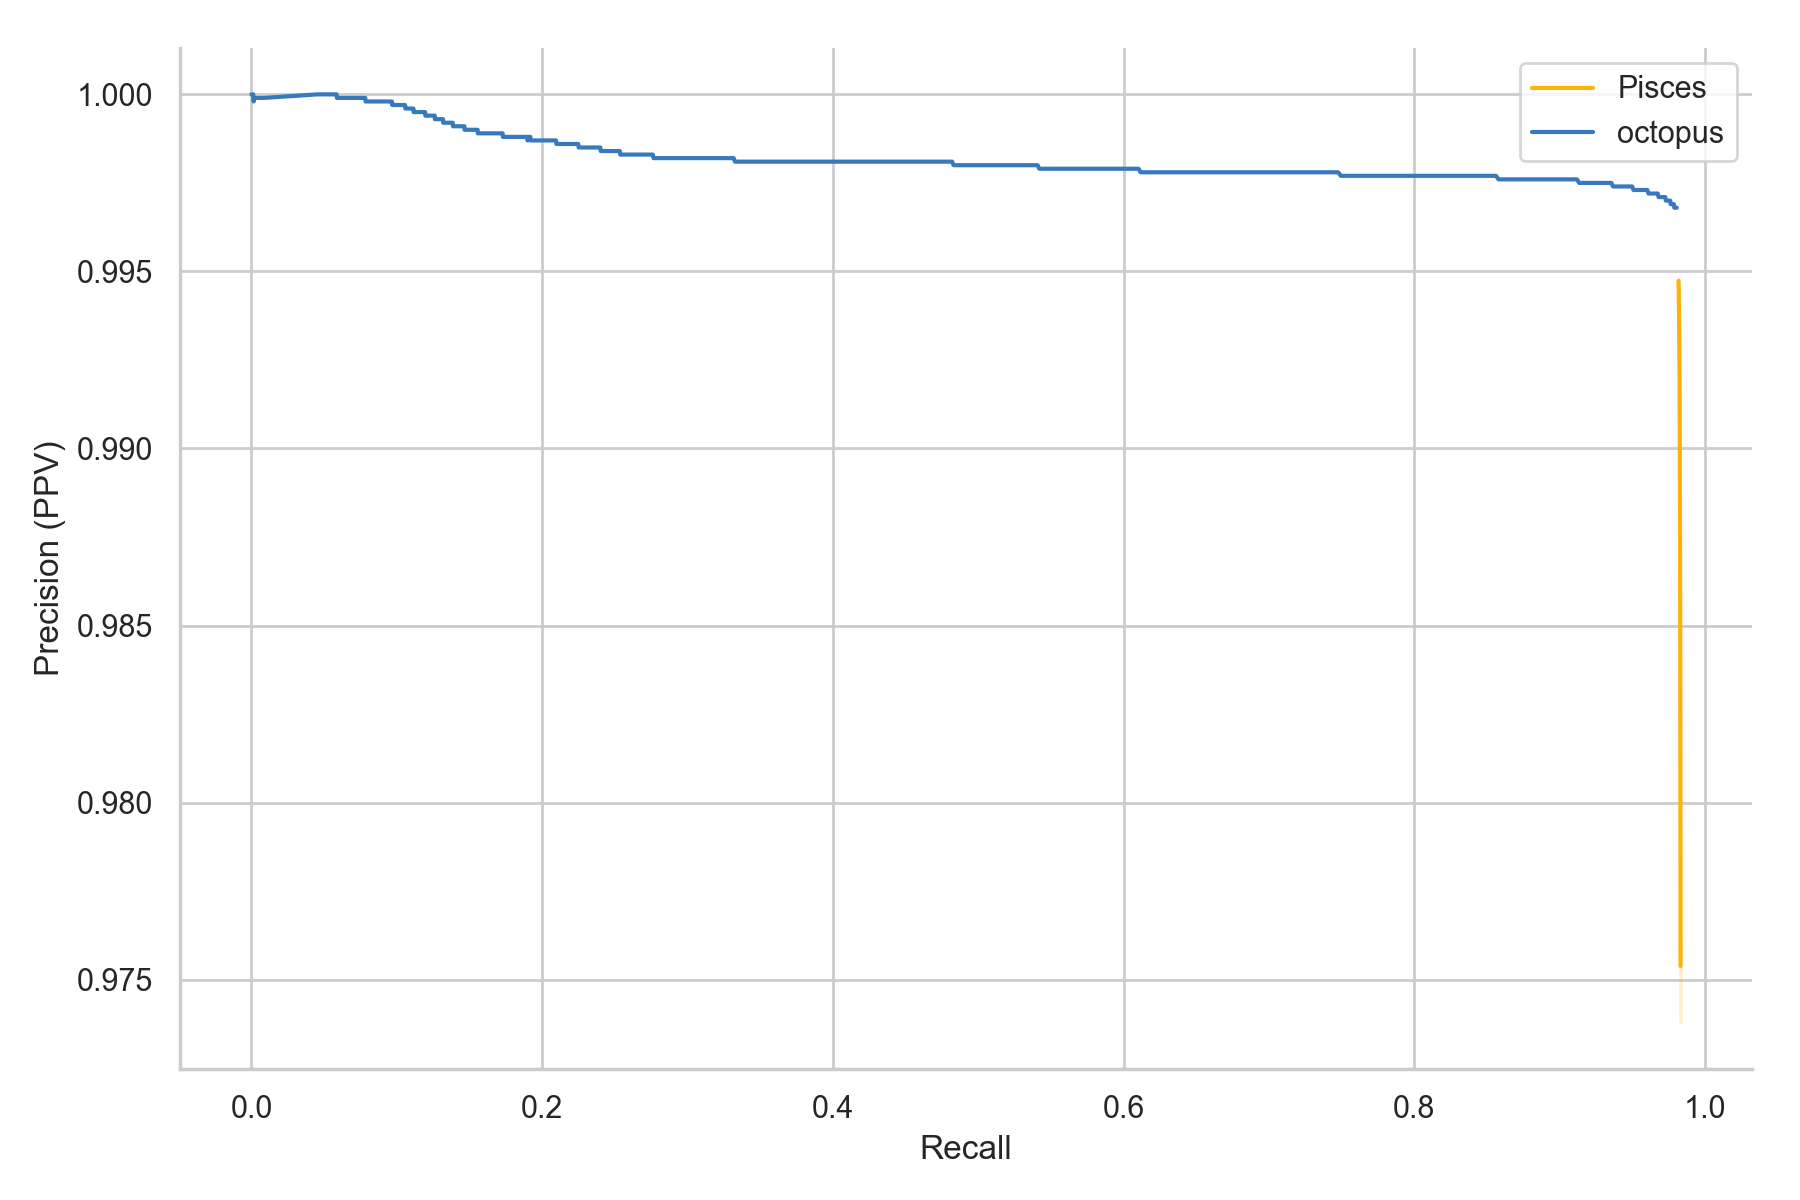

In [66]:
plot_precision_recall_helper('breast')

<IPython.core.display.Javascript object>


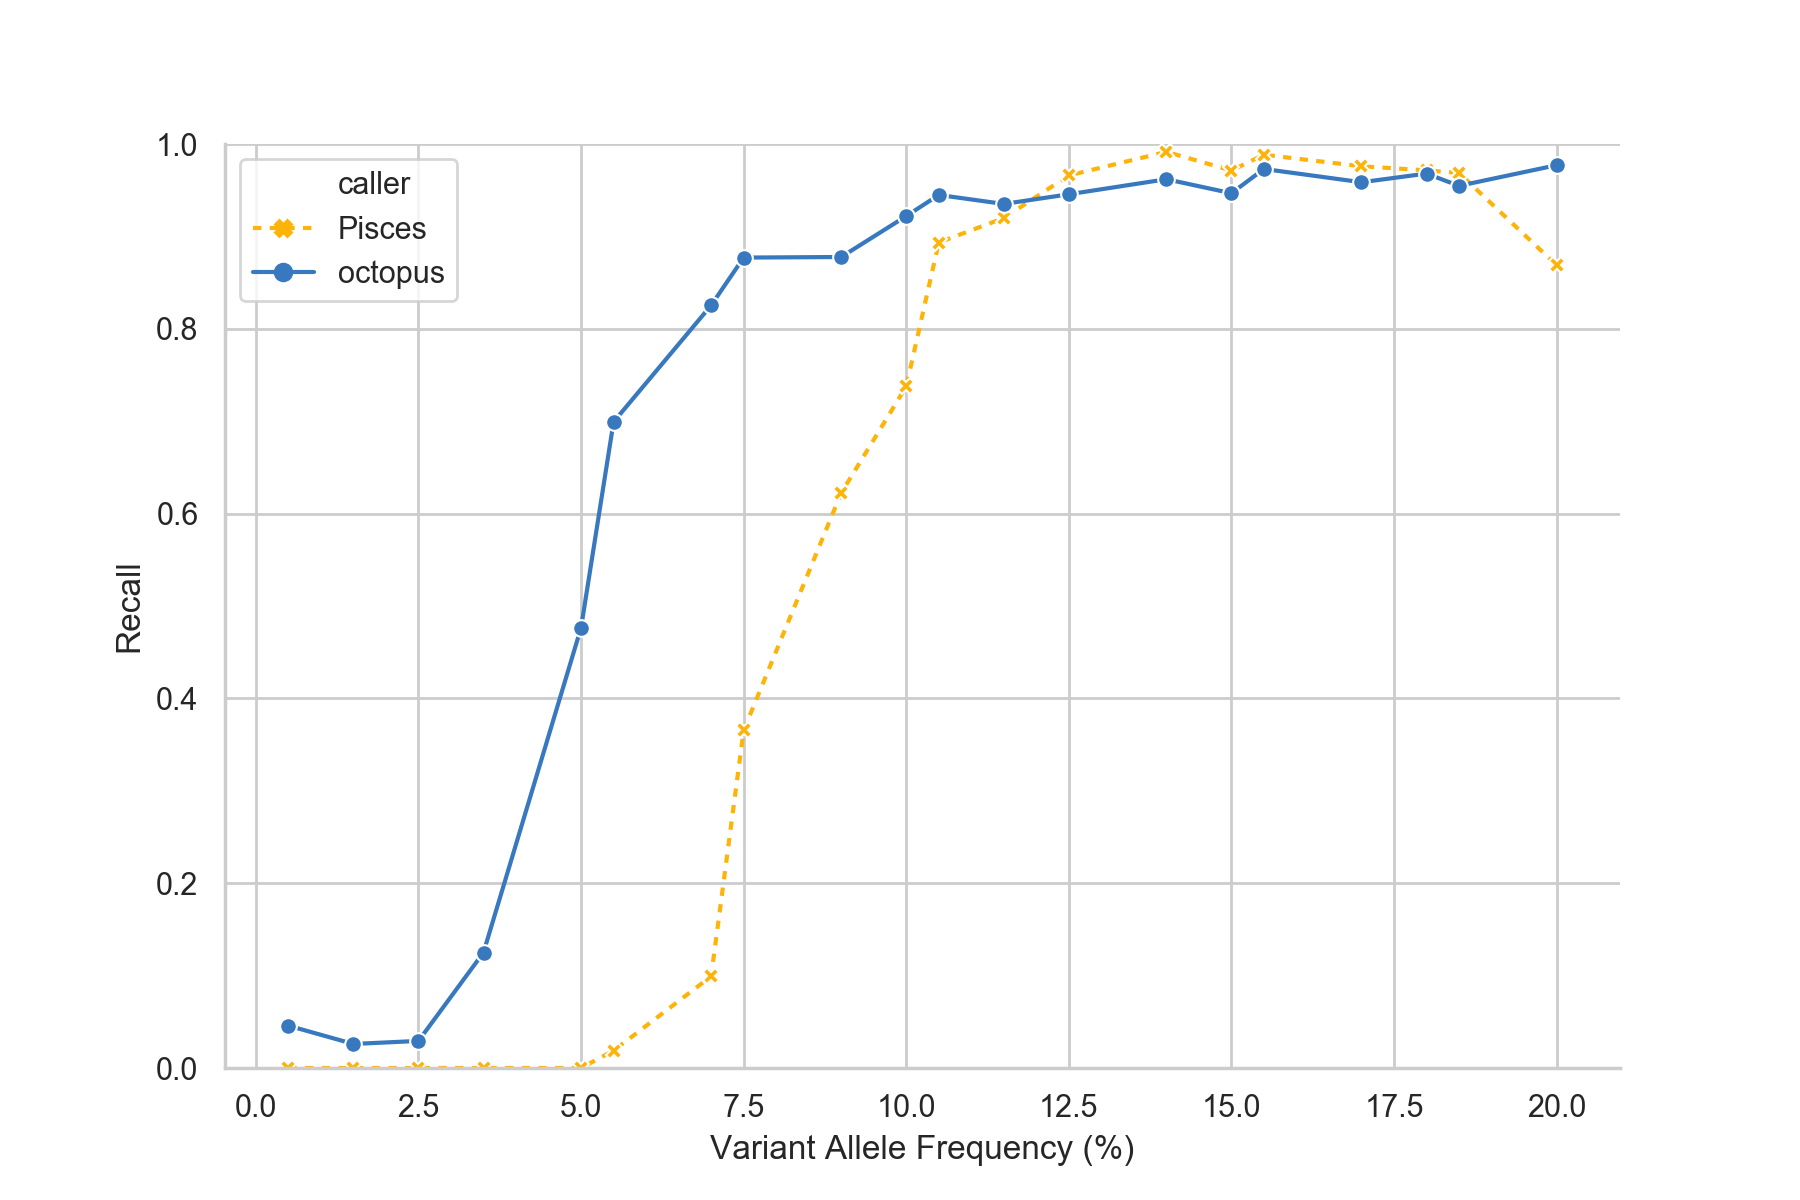

In [37]:
plot_vaf_recall_helper('breast')

<IPython.core.display.Javascript object>


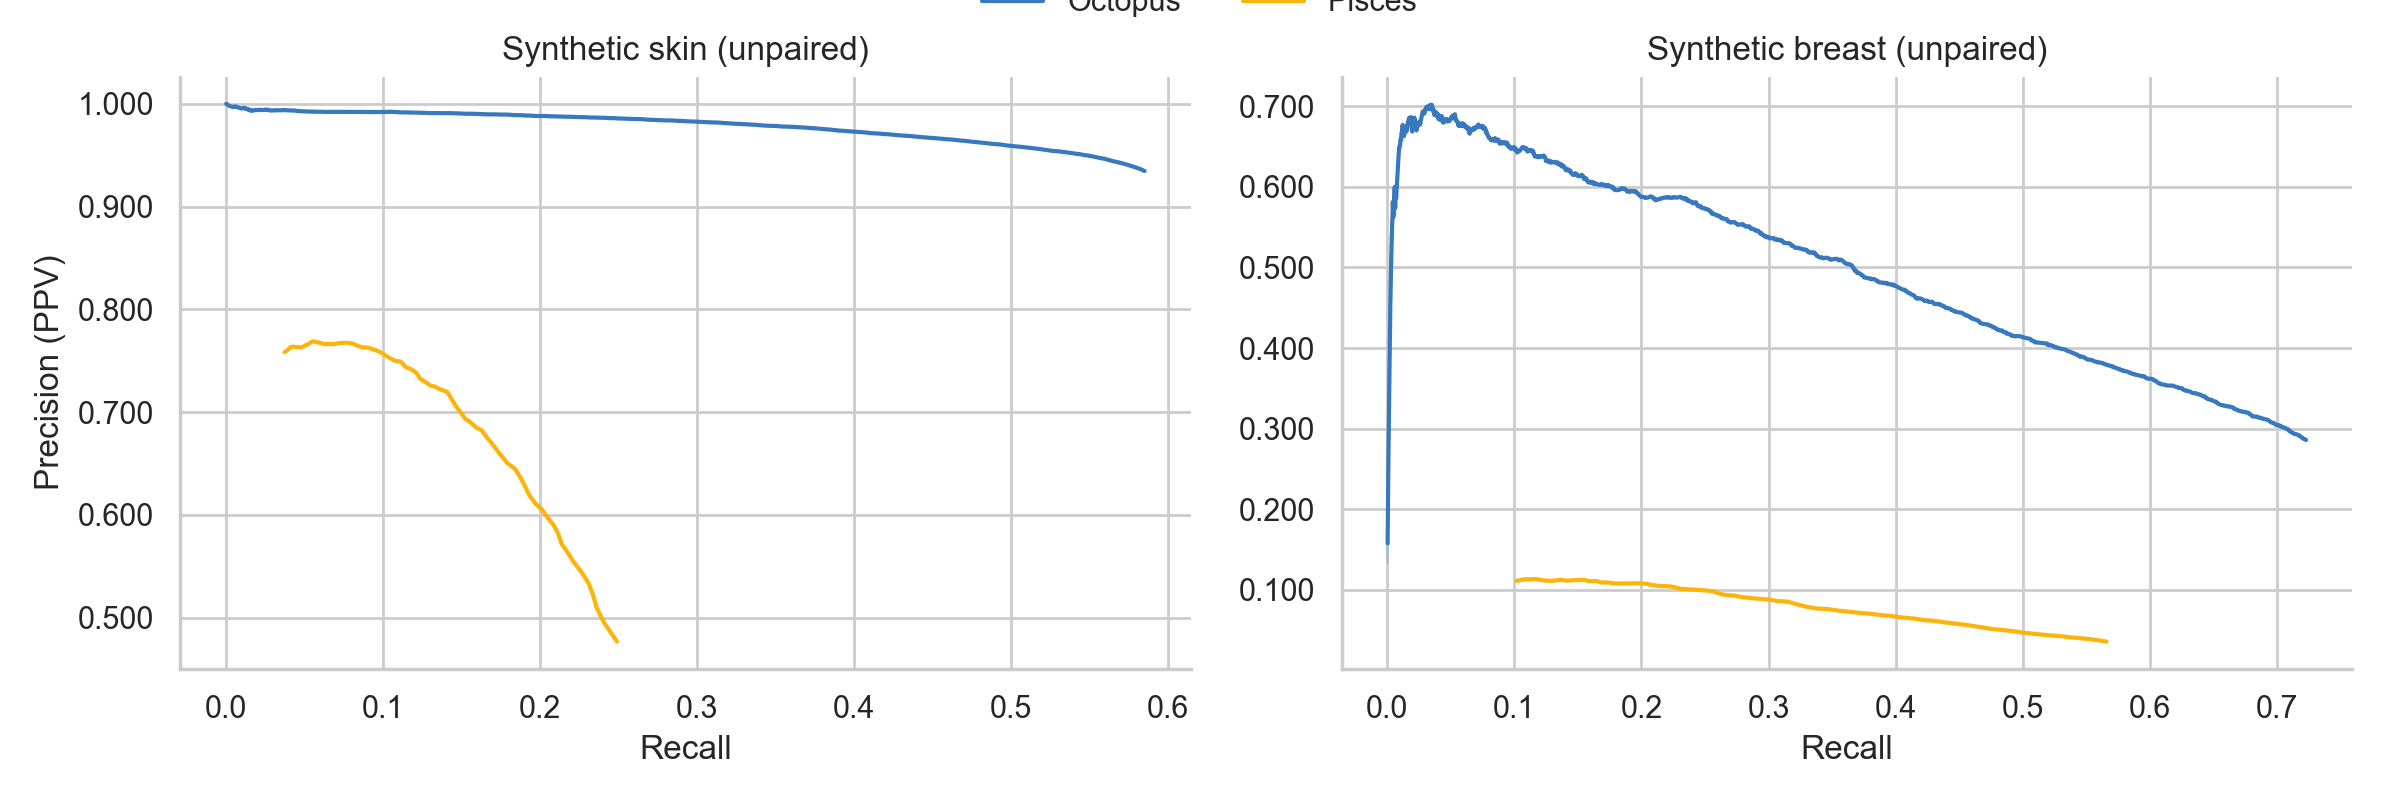

In [31]:
plot_precision_recalls_helper('skin', 'breast',
                              title1='Synthetic skin (unpaired)',
                              title2='Synthetic breast (unpaired)',
                              save="/Users/dcooke/Documents/octopus-paper/figures/tumour-only-precision-recalls.pdf")

<IPython.core.display.Javascript object>


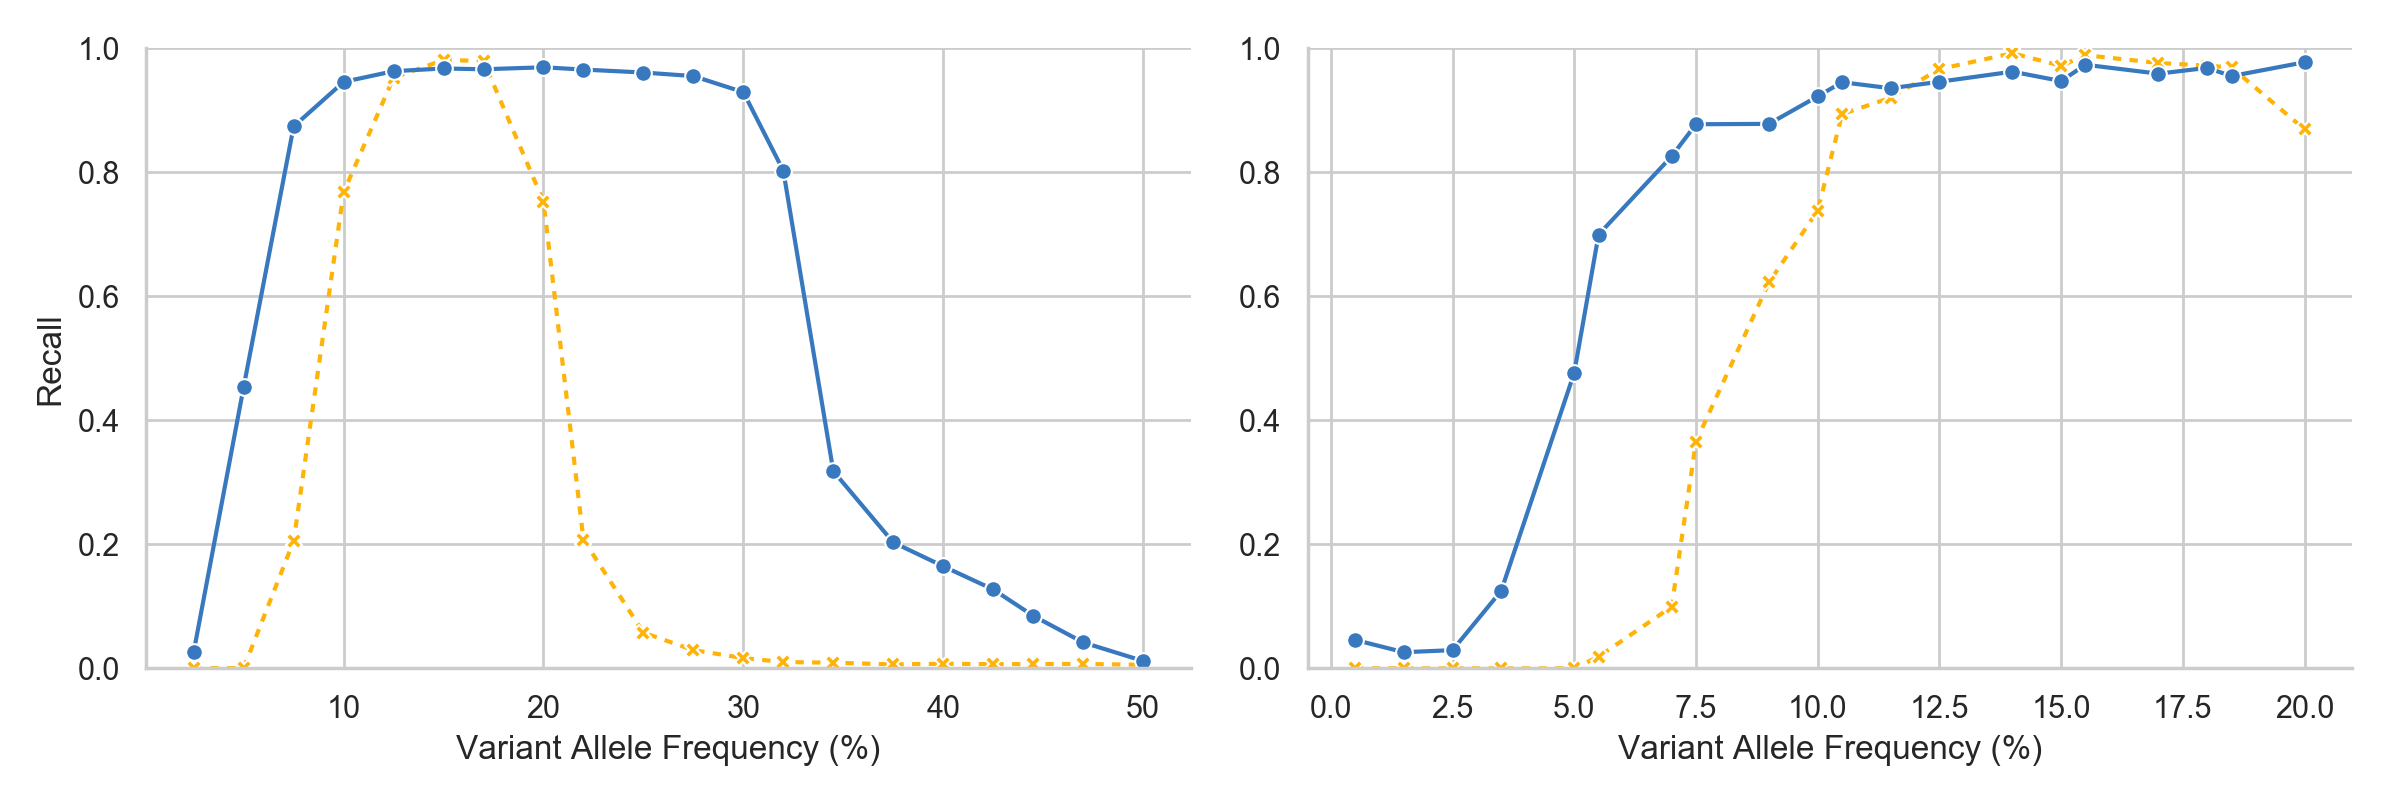

In [81]:
plot_vaf_recalls_helper('skin', 'breast',
                        legend=False,
                        save="/Users/dcooke/Documents/octopus-paper/figures/tumour-only-vaf-recalls.pdf")

In [32]:
summary_df = read_all_performance_summaries()
with open('/Users/dcooke/Documents/octopus-paper/supplementary/unpaired_somatic_summary.tex', 'w') as f:
    f.write(summary_df.to_latex(index=False))

<IPython.core.display.Javascript object>


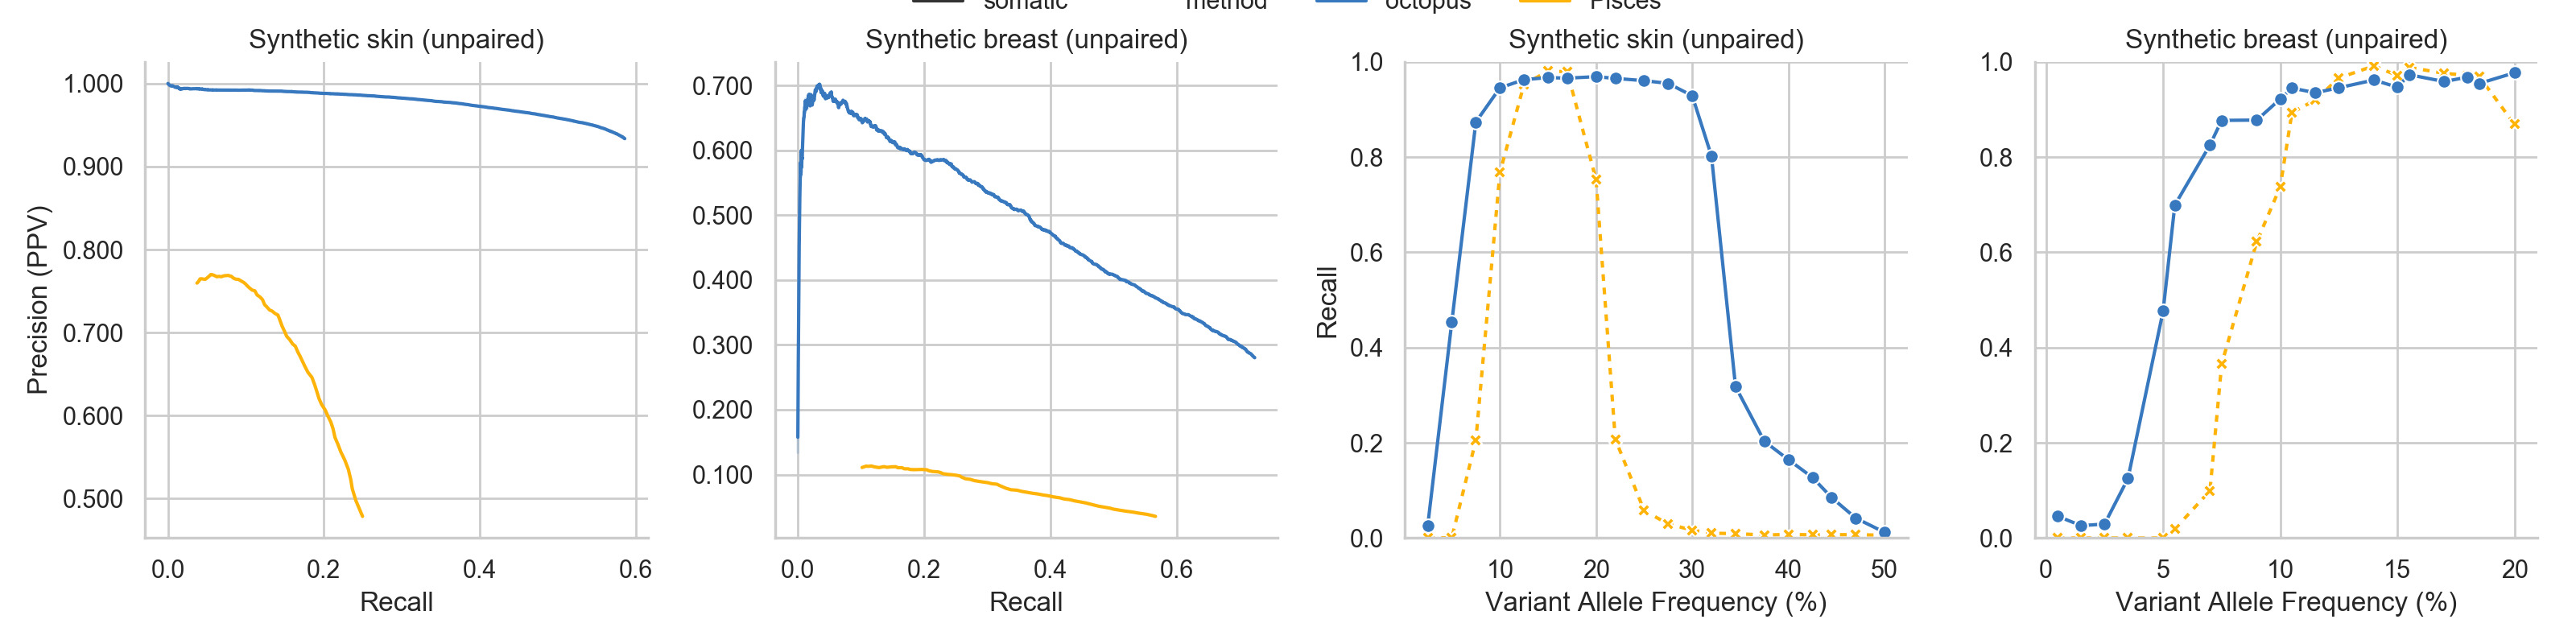

In [69]:
def plot_paper_graphs(save):
    df1 = read_rtg_rocs(rtg_eval_dirs['skin'])
    df2 = read_rtg_rocs(rtg_eval_dirs['breast'])
    df3 = read_vaf_df(rtg_eval_dirs['skin'])
    df4 = read_vaf_df(rtg_eval_dirs['breast'])
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 4))
    add_precision_recall(ax1, df1)
    add_precision_recall(ax2, df2)
    ax1.set_title('Synthetic skin (unpaired)')
    ax2.set_title('Synthetic breast (unpaired)')
    add_vaf_recall(ax3, df3)
    add_vaf_recall(ax4, df4)
    ax3.set_title('Synthetic skin (unpaired)')
    ax4.set_title('Synthetic breast (unpaired)')
    ax2.set(ylabel='')
    ax4.set(ylabel='')
    handles, labels = ax1.get_legend_handles_labels()
    lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                     frameon=False, loc='upper center',
                     bbox_to_anchor=(0.5, 1.03),
                     borderaxespad=0, ncol=len(labels))
    for ax in ax1, ax2, ax3, ax4:
        ax.legend_.remove()
    plt.tight_layout()
    plt.savefig(save, format='pdf', transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')

plot_paper_graphs("/Users/dcooke/Documents/octopus-paper/figures/tumour-only.pdf")

In [102]:
octopus_skin_misclassified_tp_vcf = join(join(rtg_eval_dirs['skin']['Octopus'], 'misclassified'), 'tp.vcf.gz')

In [115]:
vcfanno_bin = '/Users/dcooke/Genomics/apps/vcfanno'

def write_vcfanno_vaf_config(vaf_vcf, out):
    with open(out, 'w') as toml:
        toml.write('[[annotation]]\n')
        toml.write('file="' + vaf_vcf + '"\n')
        toml.write('fields=["VAF"]\n')
        toml.write('ops=["self"]\n')
        toml.write('names=["VAF"]\n')

def run_vcfanno(in_vcf, vcfanno_config, out_vcf):
    vcfanno_cmd = [vcfanno_bin, '-permissive-overlap', vcfanno_config, in_vcf]
    bgzip_cmd = ['bgzip']
    vcfanno = sp.Popen(vcfanno_cmd, stdout=sp.PIPE)
    out = open(out_vcf, 'w')
    bgzip = sp.Popen(bgzip_cmd, stdin=vcfanno.stdout, stdout=out)
    vcfanno.stdout.close()
    output = bgzip.communicate()[0]
    
def annotate_vafs(caller_vcf, truth_vcf, out_vcf):
    vcfanno_config = 'vaf.toml'
    write_vcfanno_vaf_config(truth_vcf, vcfanno_config)
    run_vcfanno(caller_vcf, vcfanno_config, out_vcf)
    remove(vcfanno_config)

def read_octopus_vaf_stats(caller_vcf, truth_vcf):
    vaf_annotated_caller_vcf = caller_vcf.replace('.vcf', '.VAF.tmp.vcf')
    annotate_vafs(caller_vcf, truth_vcf, vaf_annotated_caller_vcf)
    vcf = ps.VariantFile(vaf_annotated_caller_vcf)
    vafs, quals, pps, map_vafs, vaf_crs = [], [], [], [], []
    sample = list(vcf.header.samples)[0]
    for rec in vcf:
        if 'VAF' in rec.info and type(rec.info['VAF']) == float:
            vafs.append(round(rec.info['VAF'], 2) / 2)
            quals.append(rec.qual)
            pps.append(rec.info['PP'])
            if 'MAP_VAF' in rec.samples[sample]:
                map_vafs.append(rec.samples[sample]['MAP_VAF'])
                vaf_crs.append(rec.samples[sample]['VAF_CR'])
            else:
                map_vafs.append(None)
                vaf_crs.append(None)
    res = pd.DataFrame({'VAF': vafs, 'QUAL': quals, 'Posterior': pps, 'MAP_VAF': map_vafs, 'VAF_CR': vaf_crs})
    remove_vcf(vaf_annotated_caller_vcf)
    res['Classification confidence'] = res.apply(lambda row: max(0, min(row.Posterior / row.QUAL, 1.)), axis=1)
    return res

In [116]:
vaf_stat_df = read_octopus_vaf_stats(octopus_skin_misclassified_tp_vcf, somatic_truth_vcfs['skin'])

<IPython.core.display.Javascript object>


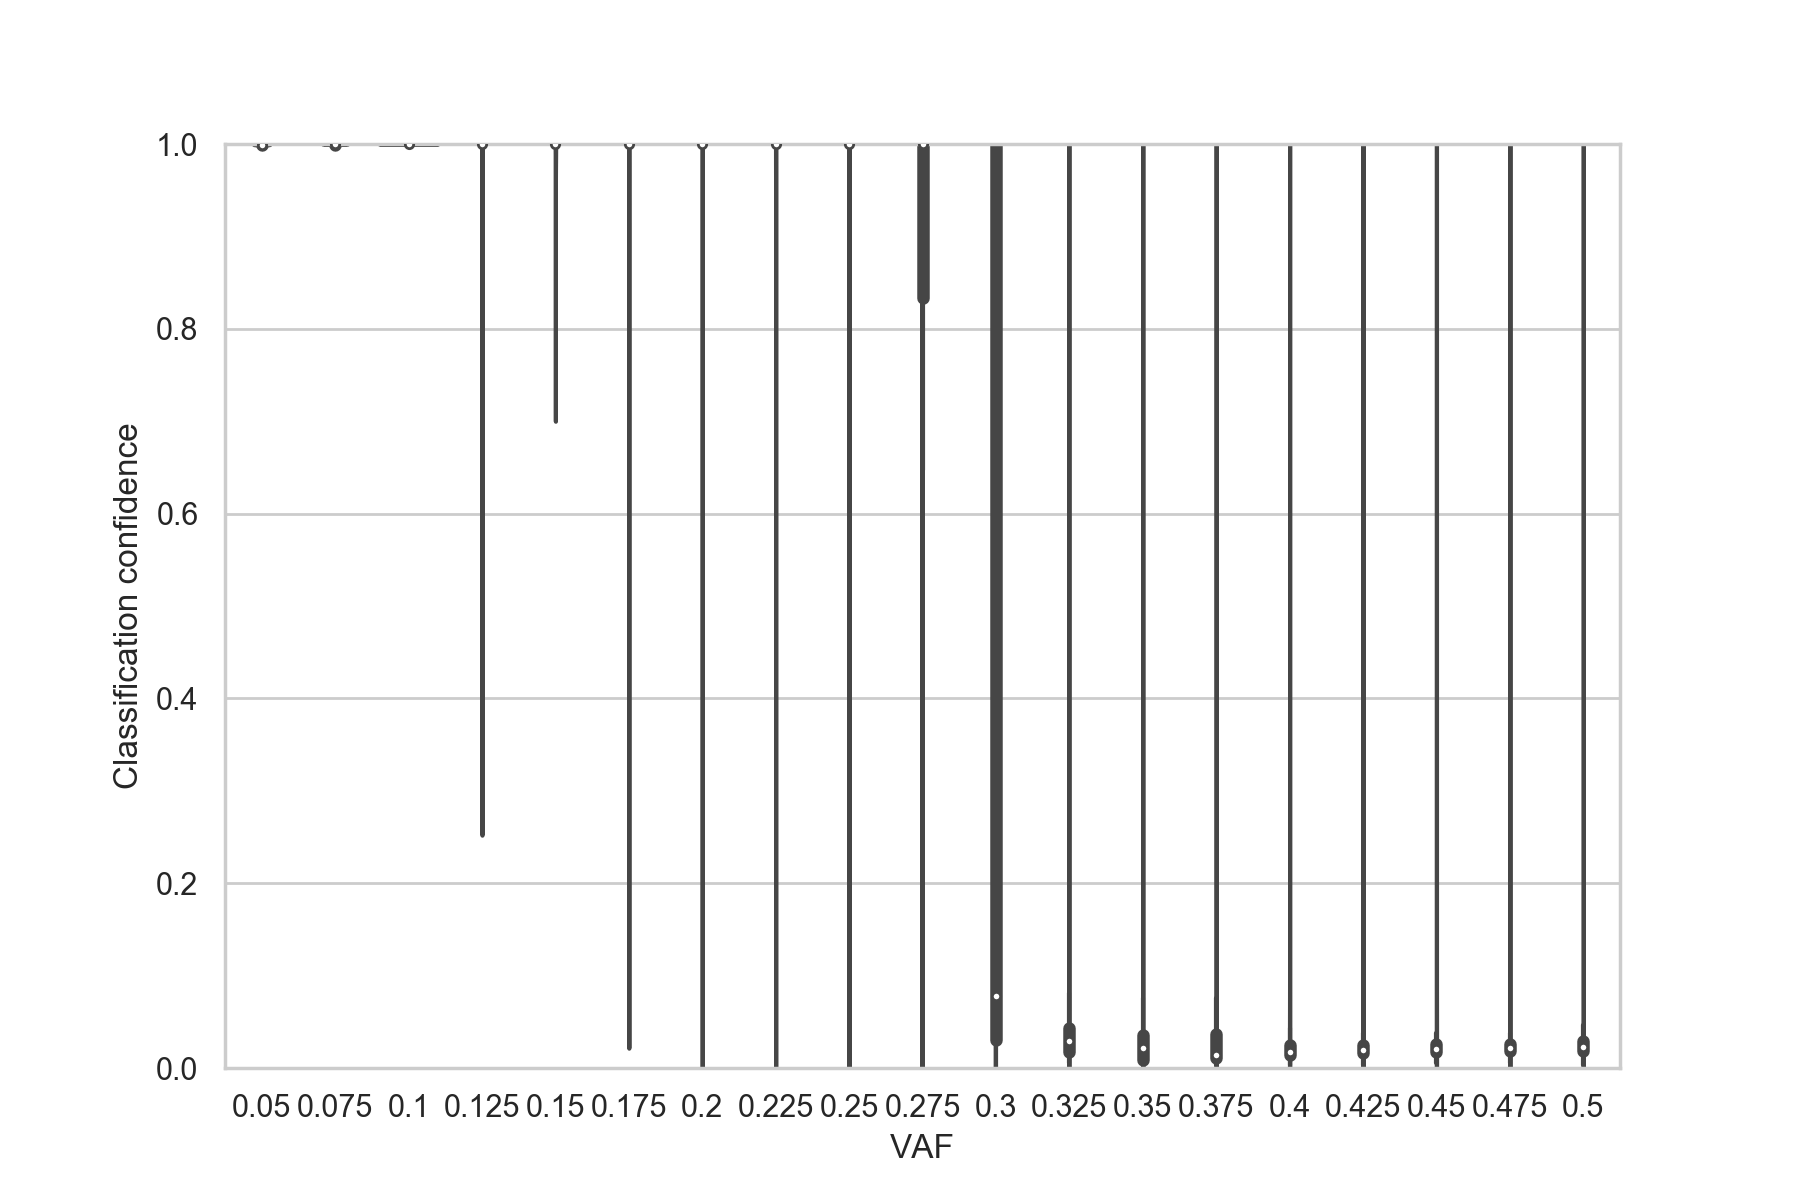

In [123]:
ax = sns.violinplot(x='VAF', y='Classification confidence', data=vaf_stat_df)
ax.set_ylim(0, 1)
plt.savefig('/Users/dcooke/Documents/octopus-paper/supplementary/figures/tumour-only-vaf-classification-confidence.pdf',
            format='pdf', transparent=True, bbox_inches='tight')